In [ ]:
import sys
from pathlib import Path

module_path = str(Path().resolve().parent / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from curvature.tvg import *
from curvature.curvature_utils import *
from soap_parser.matrix import *
from soap_parser.tvg import draw_reeb_graph

import soap_parser.report_parser as rp
import networkx as nx

# TODO : fix random seed
K = 1

### Scenario A : Data Mule

In [ ]:
scenario_a = "Data Mule"

edges_a = [(1, 2), (1, 3), (2, 4), (2, 5), (3, 6), (3, 7), (8, 9), (8, 10),
(9, 11), (9, 12), (10, 13), (10, 14), (15, 16), (15, 17), (16, 18), (16, 19),
(17, 20), (17, 21), (22, 23), (22, 24), (23, 25), (23, 26), (24, 27), (24, 28)]
edges_b = edges_a + [(0, 1), (0, 8)]
edges_c = edges_a + [(0, 15), (0, 22)]

a_list = 2 * [edges_a] + 2 * [edges_b] + 2 * [edges_a] + 2 * [edges_c]

matrix_a = IntervalMatrix(29, 29, labels = [str(k) for k in range(29)])
start = 0
for e in 10 * a_list:
    for i, j in e:
        matrix_a[i, j] |= P.closed(start, start + 1)
    start += 1
network_a = TemporalNetwork(matrix_a)

r_a = 1
sample_times_a = np.arange(0, 80, r_a).tolist()
distance_matrices_a = network_a.calculate_distances(r = r_a)
curvature_matrices_a = calculate_curvature_matrices(
    distance_matrices = distance_matrices_a,
    kernels = radius_1_uniform_kernel(network_a, sample_times_a),
    K = K,
    r = r_a
)
# print(f"A : critical times = {network_a.get_critical_times()}")

# rg_a = network_a.get_reeb_graph()
# draw_reeb_graph(rg_a)

# print(f"{[network_a.get_node_label(k) for k in network_a.graph.nodes()]}")
print(f"Network A has {len(network_a.graph.nodes())} nodes.")

### Scenario B : Starlink

In [11]:
scenario_b = "Starlink [20 Satellites]"

filepath = "./scenario_b.csv"
nodes, edges = rp.contact_analysis_report_parser(filepath)
nodes, edges = rp.filter_contact_plan(nodes, edges, substring_exclusion_list=["Mars", "Moon", "[DTC]"])

matrix_b = rp.contact_plan_to_matrix(nodes, edges)
matrix_b = matrix_b.get_submatrix(list(range(20)), list(range(20)))
network_b = TemporalNetwork(matrix_b)

r_b = 1080
sample_times_b = np.arange(0, 86_400, r_b).tolist()
distance_matrices_b = network_b.calculate_distances(r = r_b)
curvature_matrices_b = calculate_curvature_matrices(
    distance_matrices = distance_matrices_b,
    kernels = radius_1_uniform_kernel(network_b, sample_times_b),
    K = K,
    r = r_b
)

# rg_b = network_b.get_reeb_graph()
# draw_reeb_graph(rg_b)

# print(f"{[network_b.get_node_label(k) for k in network_b.graph.nodes()]}")
print(f"Network B has {len(network_b.graph.nodes())} nodes.")

Network B has 20 nodes.


### Scenario C : LunaNet

In [20]:
scenario_c = "LunaNet"

filepath = "./scenario_c.csv"
nodes, edges = rp.contact_analysis_report_parser(filepath)
nodes, edges = rp.filter_contact_plan(nodes, edges, substring_exclusion_list=["Mars", "Moon", "Madrid"])

matrix_c = rp.contact_plan_to_matrix(nodes, edges)
network_c = TemporalNetwork(matrix_c)
# print(network_c)

r_c = 1080
sample_times_c = np.arange(0, 86_400, r_c).tolist()
distance_matrices_c = network_c.calculate_distances(r = r_c)
curvature_matrices_c = calculate_curvature_matrices(
    distance_matrices = distance_matrices_c,
    kernels = radius_1_uniform_kernel(network_c, sample_times_c),
    K = K,
    r = r_c
)

# rg_c = network_c.get_reeb_graph()
# draw_reeb_graph(rg_c)

# print(f"{[network_c.get_node_label(k) for k in network_c.graph.nodes()]}")
print(f"Network C has {len(network_c.graph.nodes())} nodes.")

/home/nabu/.local/share/mamba/envs/soap/lib/python3.11/site-packages/ot/lp/__init__.py:580: UserWarning: Problem infeasible. Check that a and b are in the simplex
  check_result(result_code)


Network C has 14 nodes.


### True Reeb Graphs

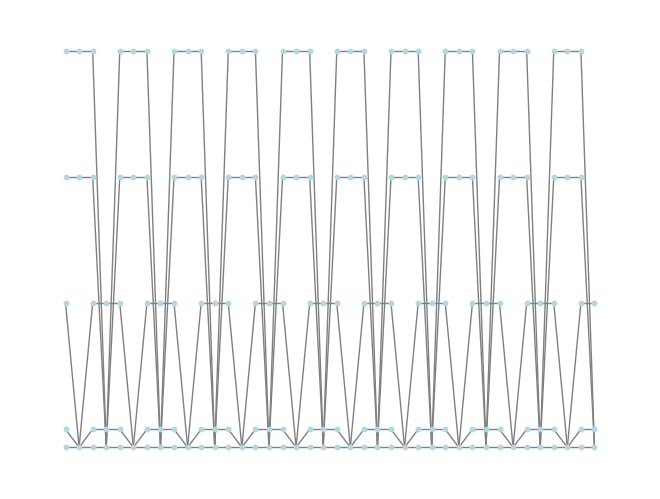

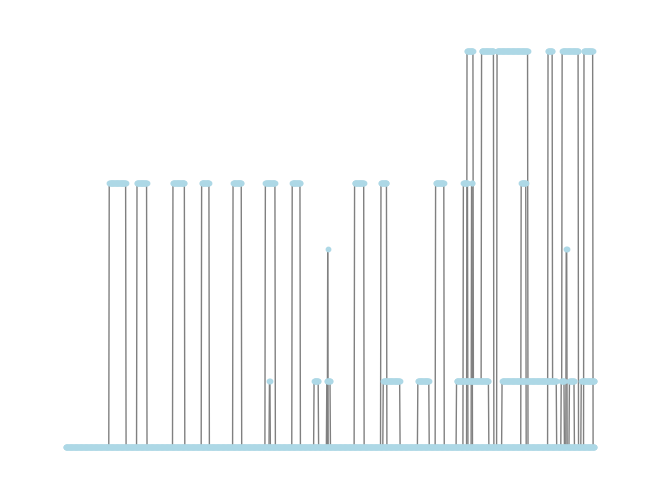

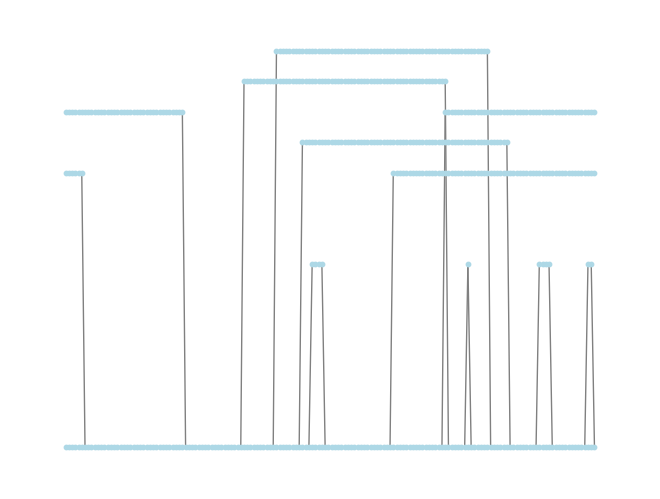

In [21]:
rg_a = network_a.get_reeb_graph()
draw_reeb_graph(rg_a)

rg_b = network_b.get_reeb_graph()
draw_reeb_graph(rg_b)

rg_c = network_c.get_reeb_graph()
draw_reeb_graph(rg_c)

### Evenly Sampled Reeb Graphs

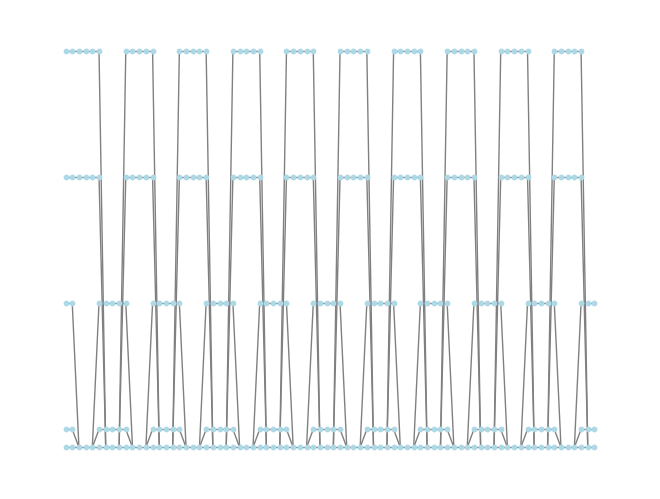

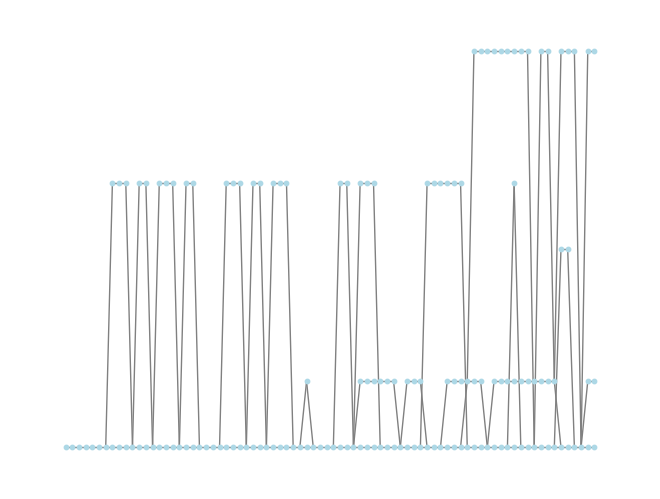

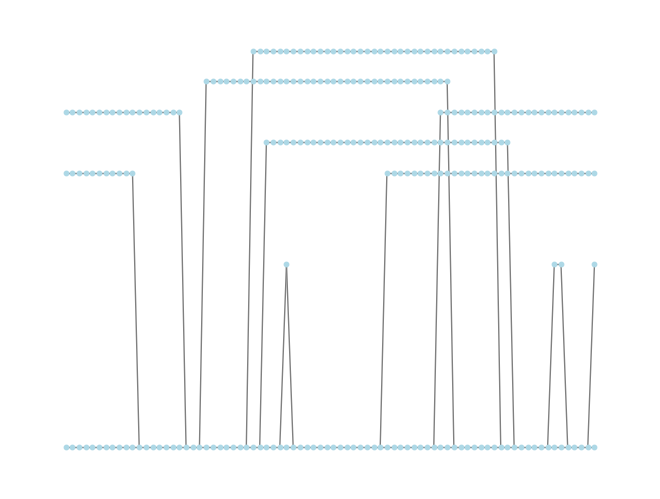

In [22]:
# scenario a : r = 1

rg_a = network_a.get_reeb_graph(sample_times_a)
draw_reeb_graph(rg_a)

# scenario's b and c : r = 1080

rg_b = network_b.get_reeb_graph(sample_times = sample_times_b)
draw_reeb_graph(rg_b)

rg_c = network_c.get_reeb_graph(sample_times = sample_times_c)
draw_reeb_graph(rg_c)

### Random Clusters

### Signatures : Toy Example

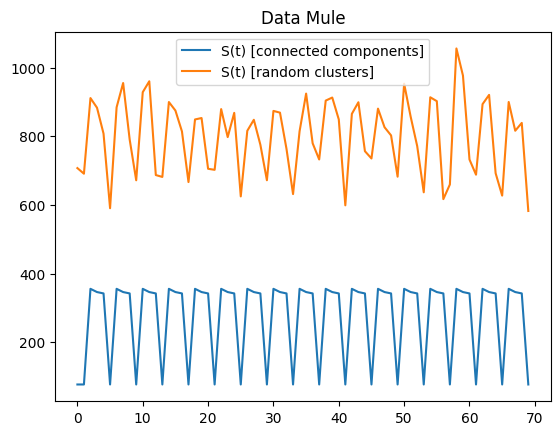

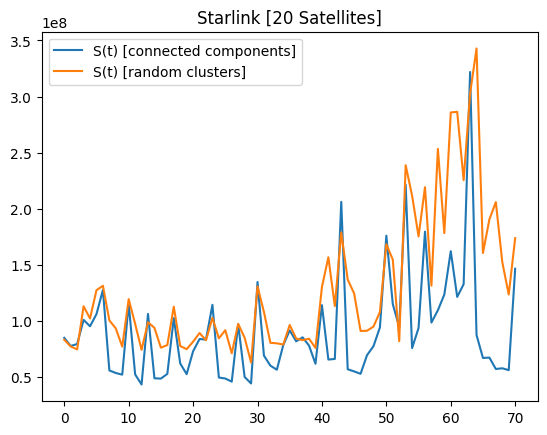

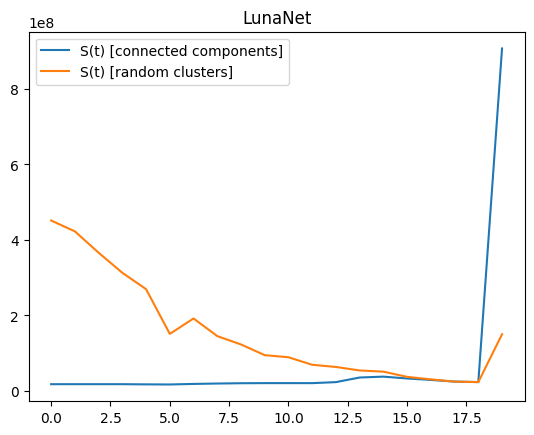

In [23]:
def plot_signatures(network, sample_times, r: float = 1, title = None) -> None:
    distance_matrices = network.calculate_distances(r = r, truncate = True)
    sample_times = sample_times[:len(distance_matrices)]
    signatures_cc = calculate_signatures(
        distance_matrices,
        build_clusters(network, sample_times)
    )
    signatures_rc = calculate_signatures(
        distance_matrices,
        build_clusters(network, sample_times, randomize = True)
    )

    # for i, s in enumerate(signatures_cc):
    #     print(f"{i} : {len(str(int(s)))} {s = }")

    if title is not None:
        plt.title(title)
    plt.plot(signatures_cc, label="S(t) [connected components]")
    plt.plot(signatures_rc, label="S(t) [random clusters]")
    plt.legend()
    plt.show()
    return None

# scenario a
plot_signatures(network_a, sample_times_a, r = r_a, title = scenario_a)

# scenario b
plot_signatures(network_b, sample_times_b, r = r_b, title = scenario_b)

# scenario c
plot_signatures(network_c, sample_times_c, r = r_c, title = scenario_c)

### Summary Graphs

Truncation T = 70 / 80


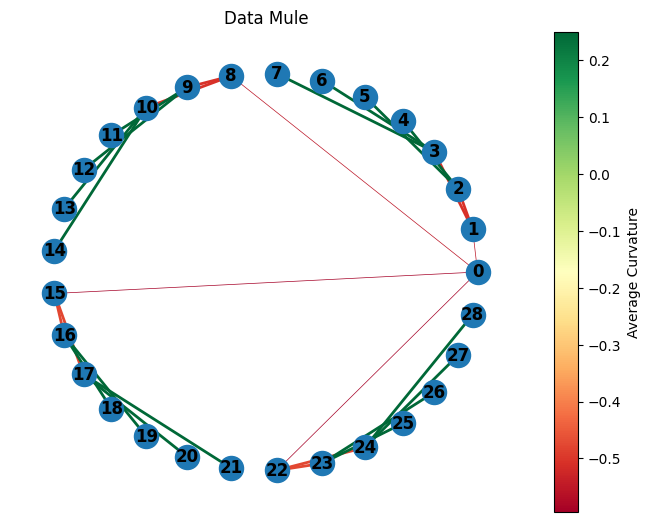

Truncation T = 71 / 80


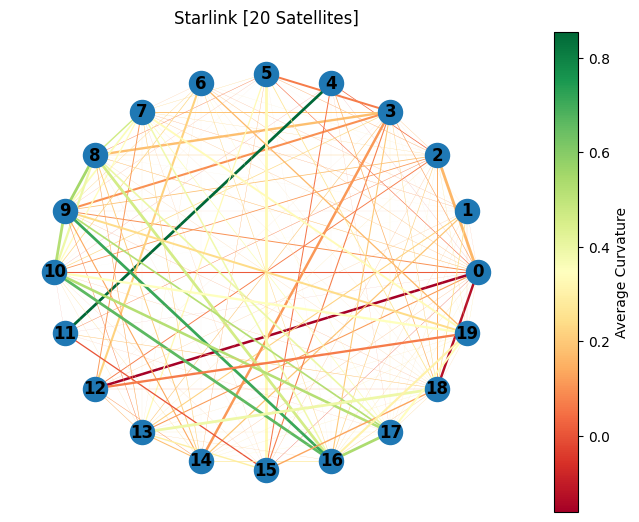

0:STARLINK-30858
1:STARLINK-30833
2:STARLINK-4206
3:STARLINK-31701
4:STARLINK-5012
5:STARLINK-3149
6:STARLINK-30700
7:STARLINK-31584
8:STARLINK-3342
9:STARLINK-5372
10:STARLINK-2651
11:STARLINK-1887
12:STARLINK-5952
13:STARLINK-5033
14:STARLINK-3982
15:STARLINK-30210
16:STARLINK-1730
17:STARLINK-4378
18:STARLINK-5642
19:STARLINK-3341
Truncation T = 20 / 80


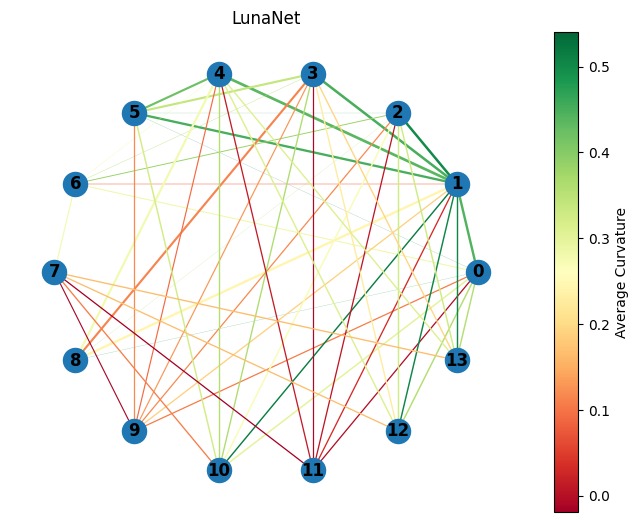

0:IOAGNorth1
1:Gateway
2:IOAGNorth2
3:IOAGSouth1
4:IOAGSouth2
5:LunarBase
6:LunarRoverFar
7:IOAGEquatorial
8:LunarRoverNear
9:DSN:Canberra
10:DSN:Goldstone
11:LEGS:Dongara
12:LEGS:Wallops
13:LEGS:WhiteSands


In [24]:
# network_a.get_summary_graph()
K = 1

draw_summary_graph(network_a, title = scenario_a, K = K, r = r_a)
# print(f"{network_a:n}")

draw_summary_graph(network_b, title = scenario_b, K = K, r = r_b)
print(f"{network_b:n}")

draw_summary_graph(network_c, title = scenario_c, K = K, r = r_c)
print(f"{network_c:n}")



### Bottleneck Analysis

### Constant Cycle / Complete Graph Temporal Networks

Truncation T = 14 / 20


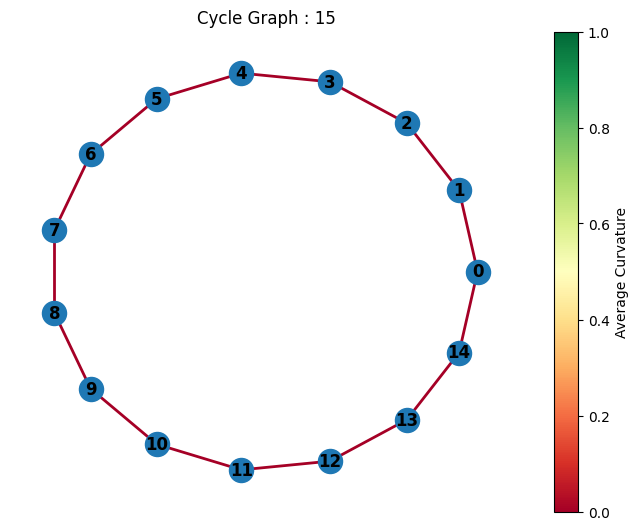

Truncation T = 20 / 20


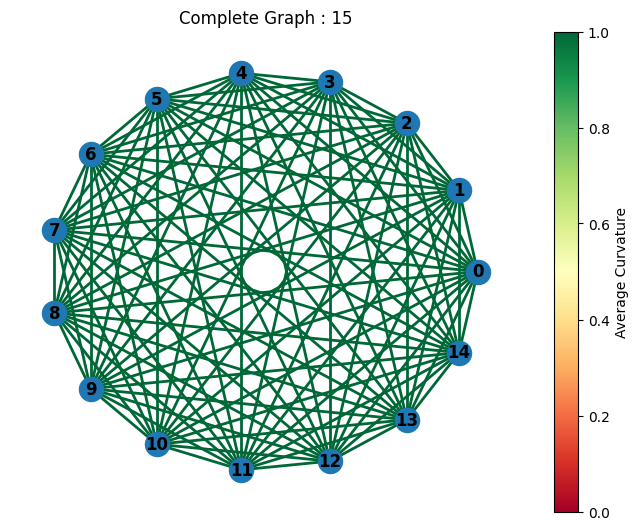

In [25]:
start, end = 0, 20

r_cg = 1
network_cg = build_cycle_tvg(n := 15, start = start, end = end)
distance_matrices_cg = network_cg.calculate_distances(r = r_cg)
sample_times_cg = np.arange(start, end, r_cg).tolist()
curvature_matrices_cg = calculate_curvature_matrices(
    distance_matrices = distance_matrices_cg,
    kernels = radius_1_uniform_kernel(network_cg, sample_times_cg),
    K = K,
    r = r_cg
)
draw_summary_graph(network_cg, title = f"Cycle Graph : {n}")

r_kg = 1
network_kg = build_complete_tvg(n := 15, start = start, end = end)
distance_matrices_kg = network_kg.calculate_distances(r = r_kg)
sample_times_kg = np.arange(start, end, r_kg).tolist()
curvature_matrices_kg = calculate_curvature_matrices(
    distance_matrices = distance_matrices_kg,
    kernels = radius_1_uniform_kernel(network_kg, sample_times_kg),
    K = K,
    r = r_kg
)
draw_summary_graph(network_kg, title = f"Complete Graph : {n}")


First `inf`/`nan` found at 14 / 20


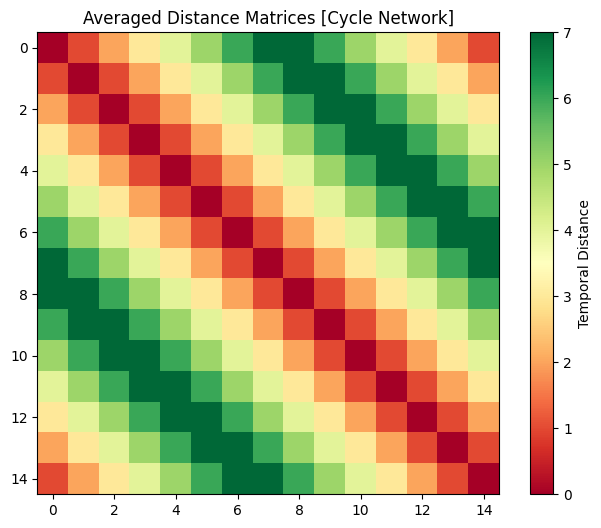

First `inf`/`nan` found at 14 / 20


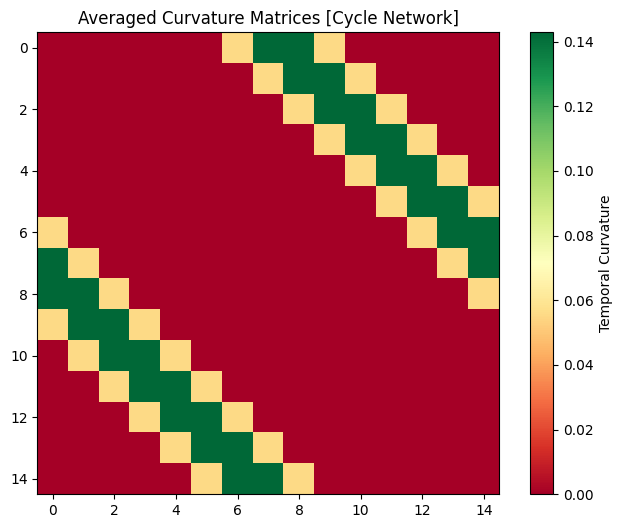

First `inf`/`nan` found at 19 / 20


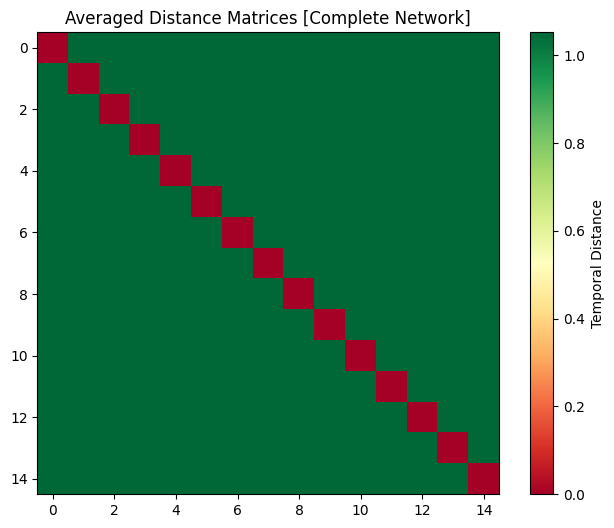

First `inf`/`nan` found at 19 / 20


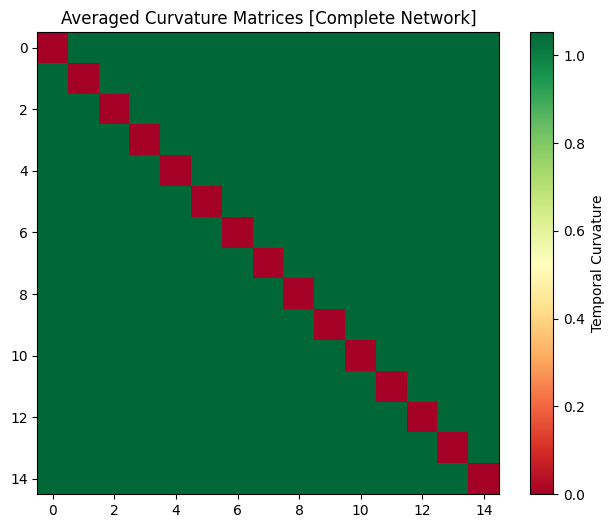

First `inf`/`nan` found at 70 / 80


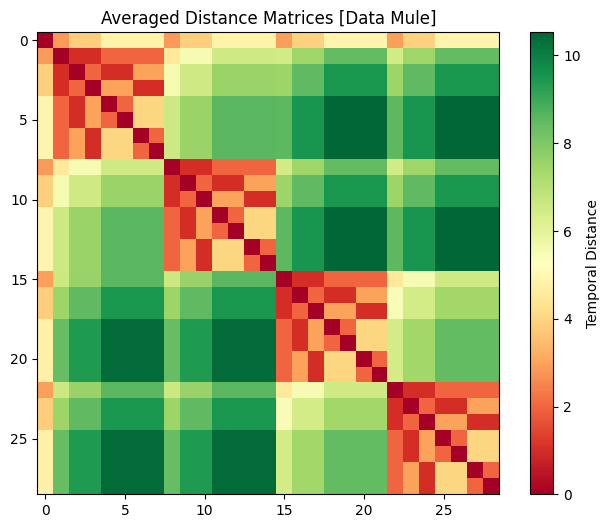

First `inf`/`nan` found at 70 / 80


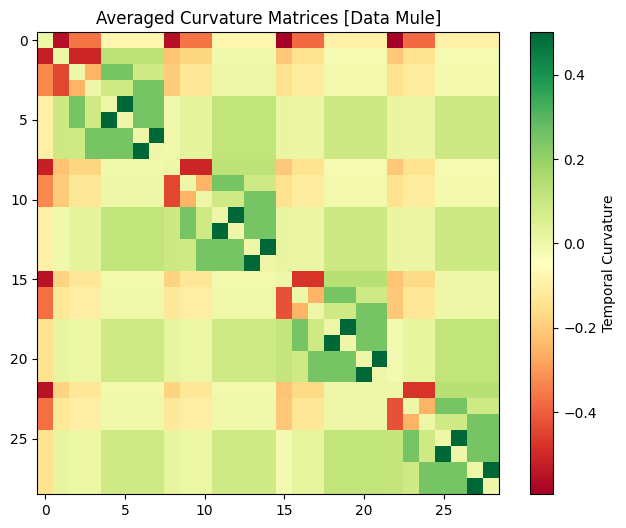

First `inf`/`nan` found at 71 / 80


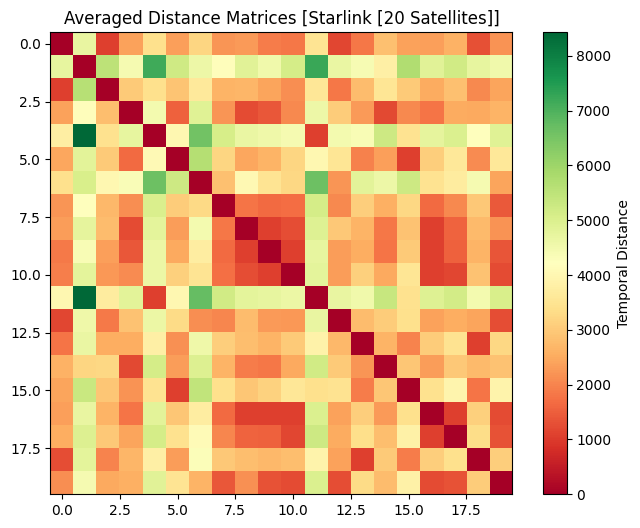

First `inf`/`nan` found at 71 / 80


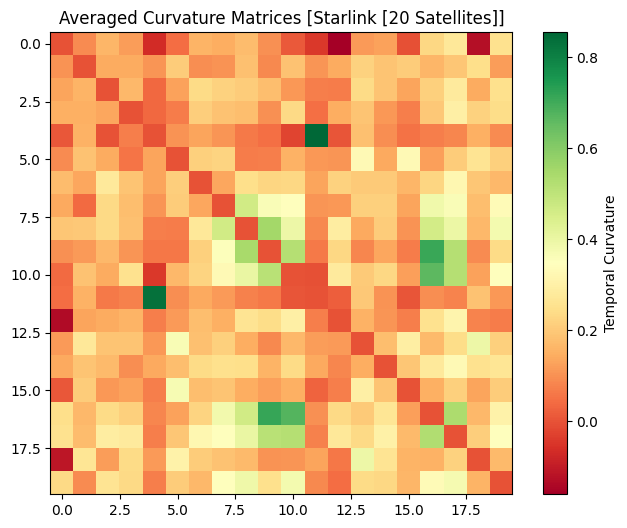

First `inf`/`nan` found at 20 / 80


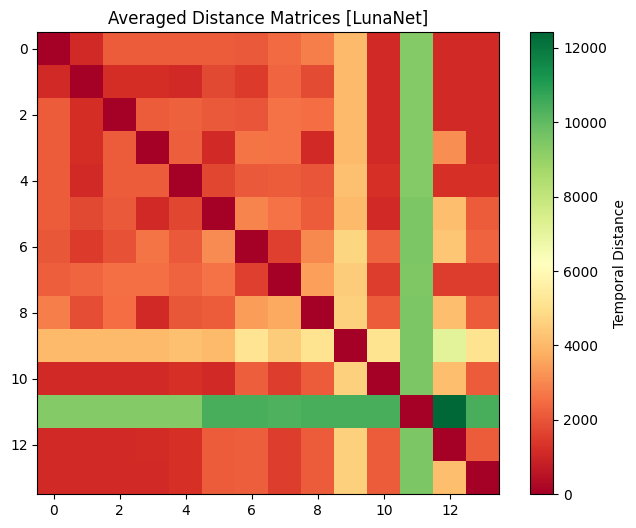

First `inf`/`nan` found at 20 / 80


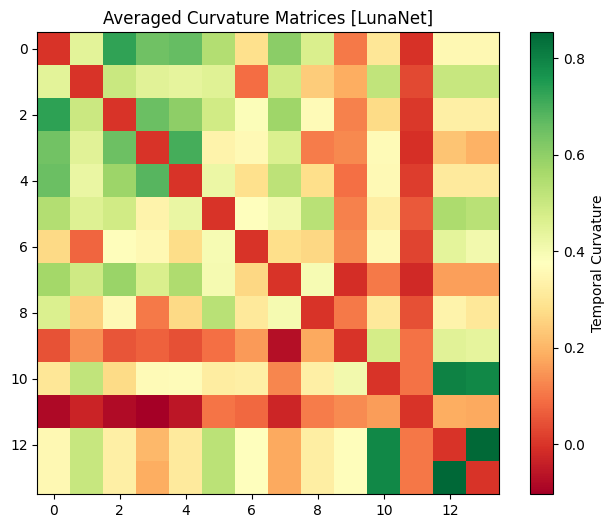

In [26]:
def plot_heatmaps(
    distance_matrices,
    title_label = None,
    colorbar_label = None,
) -> None:

    matrix = calculate_averaged_distances(distance_matrices)

    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, cmap = 'RdYlGn', interpolation = 'nearest')
    # plt.colorbar(label='Difference in Distances')
    if colorbar_label is not None:
        plt.colorbar(label = colorbar_label)
    else:
        plt.colorbar()
    # plt.title('Difference of Original vs. Curvature Low Pass Filter')
    # plt.xlabel('Column Index')
    # plt.ylabel('Row Index')
    if title_label is not None:
        plt.title(label = title_label)
    plt.show()

    return None

plot_averaged_tdm = lambda dms, label: plot_heatmaps(
    dms,
    title_label = f"Averaged Distance Matrices [{label}]",
    colorbar_label = "Temporal Distance"
)
plot_averaged_tcm = lambda dcs, label: plot_heatmaps(
    dcs,
    title_label = f"Averaged Curvature Matrices [{label}]",
    colorbar_label = "Temporal Curvature"
)

# cycle graph
# distance_matrices_cg = network_cg.calculate_distances(r = 1)
plot_averaged_tdm(distance_matrices_cg, "Cycle Network")
plot_averaged_tcm(curvature_matrices_cg, "Cycle Network")
# complete graph
# distance_matrices_kg = network_kg.calculate_distances(r = 1)
plot_averaged_tdm(distance_matrices_kg, "Complete Network")
plot_averaged_tcm(curvature_matrices_kg, "Complete Network")

# scenario a
# distance_matrices_a = network_a.calculate_distances(r = 1)
plot_averaged_tdm(distance_matrices_a, scenario_a)
plot_averaged_tcm(curvature_matrices_a, scenario_a)

# scenario b
# distance_matrices_b = network_b.calculate_distances(r = 1080)
plot_averaged_tdm(distance_matrices_b, scenario_b)
plot_averaged_tcm(curvature_matrices_b, scenario_b)

# scenario c
# distance_matrices_c = network_c.calculate_distances(r = 1080)
plot_averaged_tdm(distance_matrices_c, scenario_c)
plot_averaged_tcm(curvature_matrices_c, scenario_c)

# for i, m in enumerate(curvature_matrices_c):
#     print(f"{i} : {m[14][9] = }")
